# Titanic Challenge

The objective of this explorative analysis will be to try to find patterns that predict the survival of a passenger on the Titanic. To achieve this, we must begin by organizing the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from IPython.display import display

%matplotlib inline

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender = pd.read_csv('gender_submission.csv')

# Print the shape of the dataset (lines, columns)
print('\nData shape: ', train.shape)
        
# Count duplicated rows
df = pd.DataFrame(train)
bool_series = df.duplicated(keep ='first')
print('\nNumber of duplicated rows: ', sum(bool_series))

# Count the missing values in each column
print('\nMissing Values in each column:')
for col in train.columns:
    missing_train = train[col].isnull().sum()
    if missing_train > 0:
        print('\n\t',col, missing_train, "{0:.2%}".format(missing_train / train.shape[0]))

# Count the distinct values in each column
print('\nNumber of unique values in each column:\n')
index = 0
for col in train.nunique():
    print('\tColumn', index, ': ', col)
    index += 1


Data shape:  (891, 12)

Number of duplicated rows:  0

Missing Values in each column:

	 Age 177 19.87%

	 Cabin 687 77.10%

	 Embarked 2 0.22%

Number of unique values in each column:

	Column 0 :  891
	Column 1 :  2
	Column 2 :  3
	Column 3 :  891
	Column 4 :  2
	Column 5 :  88
	Column 6 :  7
	Column 7 :  7
	Column 8 :  681
	Column 9 :  248
	Column 10 :  147
	Column 11 :  3


In [2]:
sum(train.iloc[:,9].duplicated())

643

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The most elementary statistic we can do is determine the survival rate for a passenger, irrespective of their characteristics.

In [4]:
survivorq = train.loc[:, 'Survived'].value_counts()
survivorq_perc = train.loc[:, 'Survived'].value_counts() / train.shape[0]
print('Survival counts:\n', survivorq)
print('Survival percentage:\n', survivorq_perc)


Survival counts:
 0    549
1    342
Name: Survived, dtype: int64
Survival percentage:
 0    0.616162
1    0.383838
Name: Survived, dtype: float64


So, we have a basic 38.4% survival rate. Now, let us compare the survival rate of people grouped by different characteristics. Some ideas are:

- <b>Ticket class (`Pclass`)</b>: What if the richer class is better favored?
    
- <b>`Sex`</b>: What if women are better favored?
    
- <b>`Age`</b>: What if the young and elderly are better favored?
    
- <b>If they have siblings/spouses on board (`SibSp`)</b>: What if a parent with a child is better favored?
    
- <b>If they have parents/children on board (`ParCh`)</b>: If children are favored, wouldn't it make sense for a parent to be saved as well?
    
- <b>Cost of the ticket (`Fare`)</b>: The price of a fare might be related to premium service or availability fo the ticket. Must investigate this further.




Let us verify each one of these assertions.

## Sex

From James Cameron's picture, we figure that 'women and children' are favored over the rest of the passengers. Let us verify this notion.

In [5]:
print(train.loc[train['Sex'] == 'female', ['Sex', 'Survived']].groupby('Sex').value_counts() / train.loc[train['Sex'] == 'female'].shape[0])
print(train.loc[train['Sex'] == 'male', ['Sex', 'Survived']].groupby('Sex').value_counts() / train.loc[train['Sex'] == 'male'].shape[0])


Sex     Survived
female  1           0.742038
        0           0.257962
dtype: float64
Sex   Survived
male  0           0.811092
      1           0.188908
dtype: float64


We can see that this is true. The survival rate of women is <b>74.2%</b> whereas the survival rate of men is <b>18.9%</b>. The headers of the tables respective to each group can be found below.

In [6]:
male_pass = train.loc[train['Sex'] == 'male', :]
female_pass = train.loc[train['Sex'] == 'female', :]

male_pass.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [7]:
female_pass.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [8]:
# Renaming a dataframe
save = train.loc[train['Sex'] == 'female', ['Pclass', 'Fare']].groupby('Pclass').sum().rename(columns = {'Fare': 'Fare Sum'})
save.index.name = 'Pclass'
save

# Renaming a series
# train.loc[train['Sex'] == 'female', ['Pclass', 'Fare']].groupby('Pclass').sum()['Fare'].rename('Fare Sum')

,Fare Sum
Pclass,
1,9975.8250
2,1669.7292
3,2321.1086


## Age

Another aspect that would be intersting to study would be age ranges. Instead of iterating over a same number of years, we will distinguish these ranges based on more formal definitions, so that we can have a better understanding of the deciision-making realted to who gets a lifeboat and who doesn't.

To understand the dependence of the age with survivability, let us study its statistical distribution with respect to age.

In [9]:
male_pass.loc[male_pass['Survived'] == 0, 'Age'].describe()

count    360.000000
mean      31.618056
std       14.056019
min        1.000000
25%       21.750000
50%       29.000000
75%       39.250000
max       74.000000
Name: Age, dtype: float64

In [10]:
female_pass.loc[female_pass['Survived'] == 0, 'Age'].describe()

count    64.000000
mean     25.046875
std      13.618591
min       2.000000
25%      16.750000
50%      24.500000
75%      33.250000
max      57.000000
Name: Age, dtype: float64

We shall break down the passengers in 3 age groups, and distinguish by sex:

- Children/Early teens: 0-14 years

- Teens/Young adults: 15-24 years

- Adults: 25-64 years

- Seniors: 65+ years

Our goal is to plot graphs of the survival rate of each sex at each age bin. 

In [11]:
male_pass.loc[:, ['Survived','Sex', 'Age']];
female_pass.loc[:, ['Survived','Sex', 'Age']]['Age']

1      38.0
2      26.0
3      35.0
8      27.0
9      14.0
       ... 
880    25.0
882    22.0
885    39.0
887    19.0
888     NaN
Name: Age, Length: 314, dtype: float64

### Single bar plots

In [12]:
age_male_surv = male_pass.loc[(male_pass['Survived'] == 1) & (~male_pass['Age'].isnull()), 'Age']
age_male_tot = male_pass.loc[~male_pass['Age'].isnull(), 'Age']
age_male_tot

0      22.0
4      35.0
6      54.0
7       2.0
12     20.0
       ... 
883    28.0
884    25.0
886    27.0
889    26.0
890    32.0
Name: Age, Length: 453, dtype: float64

In [13]:
age_female_surv = female_pass.loc[(female_pass['Survived'] == 1) & (~female_pass['Age'].isnull()), 'Age']
age_female_tot = female_pass.loc[~female_pass['Age'].isnull(), 'Age']

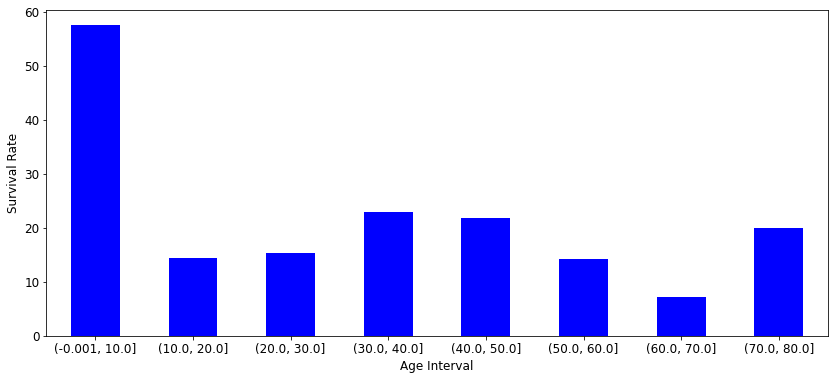

In [14]:
# Define axes
male_surv = pd.cut(age_male_surv, bins = [0,10,20,30,40,50,60,70,80], include_lowest=True)
male_tot =  pd.cut(age_male_tot, bins = [0,10,20,30,40,50,60,70,80], include_lowest=True)

# Change font size
SMALL_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

male_surv_counts = male_surv.value_counts(sort = False)
male_tot_counts = male_tot.value_counts(sort = False)

male_perc_norm = male_surv_counts / male_tot_counts * 100

ax = male_perc_norm.plot.bar(rot = 0, color = "b", figsize = (14,6))
plt.ylabel("Survival Rate")
plt.xlabel("Age Interval")
plt.show()

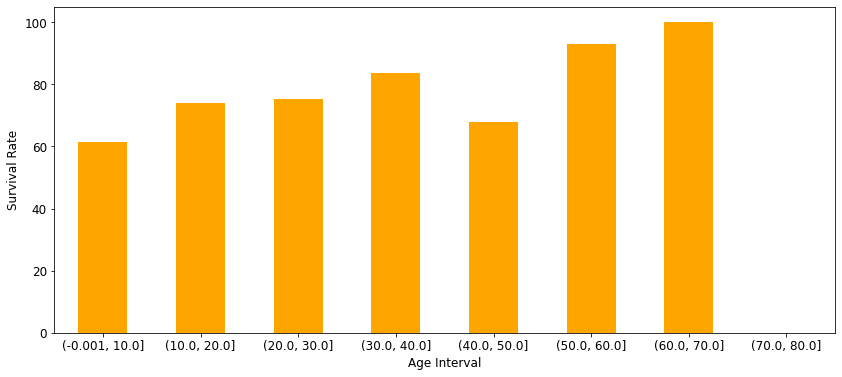

In [15]:
# Define axes
female_surv = pd.cut(age_female_surv, bins = [0,10,20,30,40,50,60,70,80], include_lowest=True)
female_tot =  pd.cut(age_female_tot, bins = [0,10,20,30,40,50,60,70,80], include_lowest=True)

# Change font size
SMALL_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

female_surv_counts = female_surv.value_counts(sort = False)
female_tot_counts = female_tot.value_counts(sort = False)

female_perc_norm = female_surv_counts / female_tot_counts * 100

ax = female_perc_norm.plot.bar(rot = 0, color = "orange", figsize = (14,6))
plt.ylabel("Survival Rate")
plt.xlabel("Age Interval")
plt.show()

### Multi-bar plot

Combining the graphs in the previous item:

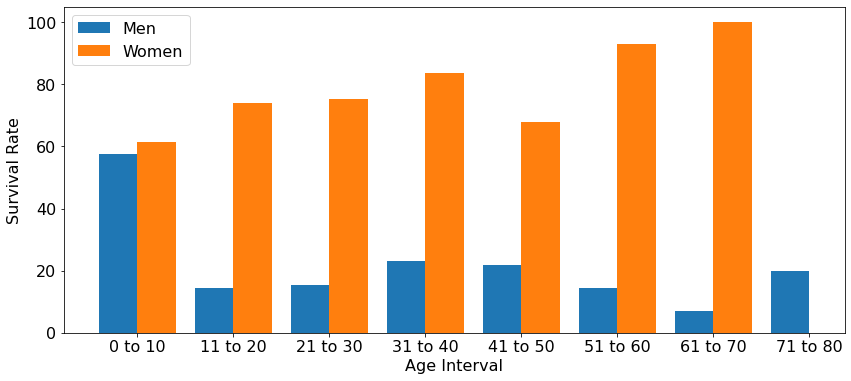

In [16]:
# Define axes
x = ['0 to 10','11 to 20', '21 to 30', '31 to 40', '41 to 50','51 to 60','61 to 70', '71 to 80']
x_axis = np.arange(len(x))
y0 = male_perc_norm
y1 = female_perc_norm

# Change font size
SMALL_SIZE = 16
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

# Multi-bar plot
plt.figure(figsize = (14,6))
plt.bar(x_axis - 0.2, y0, 0.4, label = 'Men')
plt.bar(x_axis + 0.2, y1, 0.4, label = 'Women')
plt.xticks(x_axis, x)
plt.ylabel("Survival Rate")
plt.xlabel("Age Interval")
plt.legend()
plt.show()

The survivability of women is higher than that of men, across the entire board. The only instance where they are comparable is in the ages 0 to 10.

In [17]:
print(male_perc_norm, female_perc_norm)

(-0.001, 10.0]    57.575758
(10.0, 20.0]      14.492754
(20.0, 30.0]      15.436242
(30.0, 40.0]      23.000000
(40.0, 50.0]      21.818182
(50.0, 60.0]      14.285714
(60.0, 70.0]       7.142857
(70.0, 80.0]      20.000000
Name: Age, dtype: float64 (-0.001, 10.0]     61.290323
(10.0, 20.0]       73.913043
(20.0, 30.0]       75.308642
(30.0, 40.0]       83.636364
(40.0, 50.0]       67.741935
(50.0, 60.0]       92.857143
(60.0, 70.0]      100.000000
(70.0, 80.0]             NaN
Name: Age, dtype: float64


## Ticket class

The first thing we will investigate is information on the ticket classes.

In [18]:
train.loc[:, ['Pclass', 'Fare']].groupby('Pclass').describe()

Fare                                                              
        count       mean        std  min       25%      50%   75%       max
Pclass                                                                     
1       216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292
2       184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000
3       491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500

What is interesting in these prices is that the minimum is 0. This might be an indicator of crew members. Let us count these.

### Survival rate per class

In [19]:
fare_total = train['Pclass'].value_counts()
fare_surv = train.loc[train['Survived'] == 1, 'Pclass'].value_counts()
fare_surv / fare_total * 100

1    62.962963
2    47.282609
3    24.236253
Name: Pclass, dtype: float64

In [20]:
male_pass.loc[train['Survived'] == 1, 'Pclass'].value_counts()

3    47
1    45
2    17
Name: Pclass, dtype: int64

In [21]:
m_fare_total = male_pass.loc[:,'Pclass'].value_counts()
m_fare_surv = male_pass.loc[train['Survived'] == 1, 'Pclass'].value_counts()
m_fare_surv_perc = m_fare_surv / m_fare_total * 100

f_fare_total = female_pass.loc[: , 'Pclass'].value_counts()
f_fare_surv = female_pass.loc[train['Survived'] == 1, 'Pclass'].value_counts()
f_fare_surv_perc = f_fare_surv / f_fare_total * 100

In [22]:
m_fare_surv_perc.sort_index()

1    36.885246
2    15.740741
3    13.544669
Name: Pclass, dtype: float64

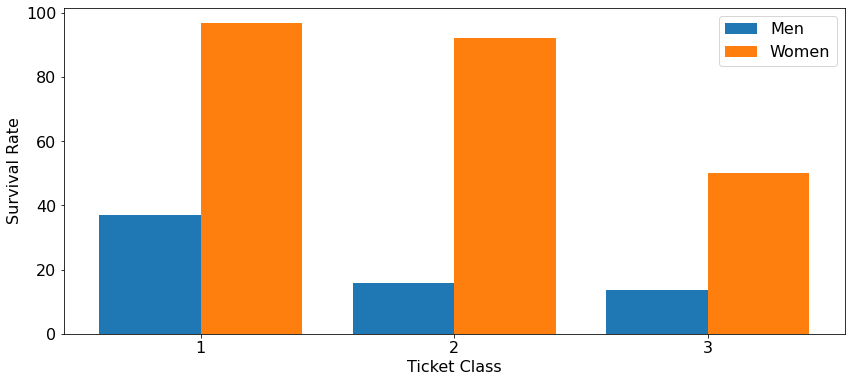

In [23]:
# Define axes
x = ['1', '2', '3']
x_axis = np.arange(len(x))
y0 = m_fare_surv_perc.sort_index()
y1 = f_fare_surv_perc.sort_index()

# Change font size
SMALL_SIZE = 16
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

# Multi-bar plot
plt.figure(figsize = (14,6))
plt.bar(x_axis - 0.2, y0, 0.4, label = 'Men')
plt.bar(x_axis + 0.2, y1, 0.4, label = 'Women')
plt.xticks(x_axis, x)
plt.ylabel("Survival Rate")
plt.xlabel("Ticket Class")
plt.legend()
plt.show()

It is clear that the higher class tickets increases one's survivability.

### Free ticket passengers

In [24]:
train.loc[train.Fare == 0.0, ['Pclass', 'Fare']].groupby('Pclass').value_counts()

Pclass  Fare
1       0.0     5
2       0.0     6
3       0.0     4
dtype: int64

We have 15 passengers that did not pay fairs.

In [25]:
train.loc[train.Fare == 0.0,:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


We further note that all these passengers are male and all of them embarked in Southampton. Upon research in google, I discovered some additional pieces of information. First, the reason some of these have 'LINE' tickets is likely due to their affiliation with a New York ship company, the 'American Line'. This was confirmed by Googling the one survivor among these passengers - Mr. William Henry Tornquist -, who was employed to the American Line.

In other words, the employees of the American Line were supposed to return to New York in another vessel, but due to a coal strike in Britain, tehy were awarded free 3rd class tickets to the Titanic.

In [26]:
train.loc[(train.Fare == 0.0) & (train.Ticket == 'LINE'),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S


In [27]:
train.loc[train.Fare == 0.0, 'Survived'].value_counts() / train.loc[train.Fare == 0.0, 'Survived'].shape[0]

0    0.933333
1    0.066667
Name: Survived, dtype: float64

Therefore, there is no necessary correlation with free tickets and being a crew member, apparently.

By googling one of the random passengers among these with free tickets, Mr. Alfred Flemming Cunningham, I discovered that Alfred was one of the nine-strong "guarantee group" of Harland and Wolff employees chosen to oversee the smooth running of the Titanic's maiden voyage. This means we could account for 9 + 4 = 13 free tickets. 

We will not indulge in further specifics on this matter. What we have learned from the inspection of this peculiar quality (free ticket fare) was that there is no single reason for this ticket to be free, and therefore the fact that there is such a low survival rate for members of this group (<b>6.7%</b>) compared to the average surival rate (<b>38.4%</b>) is more likely to be the result of coincidence.

## Family

What I'd like to uncover in this section of the analysis is how Siblings/Spouses or Parents/Children influences the chances of survival.

### `SibSp`

In [28]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In this case, it would be interesting to calculate the survival rate in each one of the SibSp groups above. Also, since the sex is a remarkably significant characteristic when considering survival, it would be interesting to make graphs similar to the one present in section <b>3.2</b>. 

In [29]:
sibsp_counts = train.loc[: , ['SibSp', 'PassengerId']].groupby('SibSp').count()
sibsp_surv_counts = train.loc[train['Survived'] == 1, ['SibSp', 'PassengerId']].groupby('SibSp').count()
sibsp_perc_surv = sibsp_surv_counts / sibsp_counts * 100
sibsp_perc_surv = sibsp_perc_surv.replace(np.nan, 0)
sibsp_perc_surv

,PassengerId
SibSp,
0,34.539474
1,53.588517
2,46.428571
3,25.000000
4,16.666667
5,0.000000
8,0.000000


The survival rate seems to cap out at a single sibling/spouse. What is curious is that, starting from 1, the larger the familiy, the lower the chances of survival. This might be a reflection of the fact that siblings/spouses refuse to leave their significant other(s) behind to die. It's either all of them, or none.

### Separating by sex

In [30]:
m_sibsp_perc_surv.shape

NameError: name 'm_sibsp_perc_surv' is not defined

In [ ]:
m_sibsp_counts = train.loc[train['Sex'] == 'male', ['SibSp', 'PassengerId']].groupby('SibSp').count()
m_sibsp_surv_counts = train.loc[(train['Sex'] == 'male') & (train['Survived'] == 1), ['SibSp', 'PassengerId']].groupby('SibSp').count()
f_sibsp_counts = train.loc[train['Sex'] == 'female', ['SibSp', 'PassengerId']].groupby('SibSp').count()
f_sibsp_surv_counts = train.loc[(train['Sex'] == 'female') & (train['Survived'] == 1), ['SibSp', 'PassengerId']].groupby('SibSp').count()

m_sibsp_perc_surv = m_sibsp_surv_counts / m_sibsp_counts * 100
f_sibsp_perc_surv = f_sibsp_surv_counts / f_sibsp_counts * 100

m_sibsp_perc_surv = m_sibsp_perc_surv.replace(np.nan, 0)
f_sibsp_perc_surv = f_sibsp_perc_surv.replace(np.nan, 0)

In [ ]:
# Define Axes
x = sibsp_counts
y = m_sibsp_perc_surv

# Set font size
SMALL_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

# Plot the graph
ax = m_sibsp_perc_surv.plot.bar(rot = 0, color = "blue", figsize = (14,6), label = 'Survival Rate')
plt.legend()
plt.show()

In [ ]:
# Define Axes
x = sibsp_counts
y = f_sibsp_perc_surv

# Set font size
SMALL_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

# Plot the graph
ax = f_sibsp_perc_surv.plot.bar(rot = 0, color = "orange", figsize = (14,6), label = 'Survival Rate')
plt.legend()
plt.show()

In [ ]:
sibsp_counts

In [ ]:
m_sibsp_perc_surv.replace(np.nan, 0)

### `ParCh`

In [ ]:
train['Parch'].value_counts()

In [ ]:
parch_counts = train.loc[: , ['Parch', 'PassengerId']].groupby('Parch').count()
parch_surv_counts = train.loc[train['Survived'] == 1, ['Parch', 'PassengerId']].groupby('Parch').count()

In [ ]:
parch_perc_surv = parch_surv_counts / parch_counts
parch_perc_surv = parch_perc_surv.replace(np.nan, 0)
parch_perc_surv

In the `SibSp` column, we cannot distinguish having Siblings to having a Spouse. However, in the time of the Titanic (year <b>1912</b>), there was no such thing as gay marriage. Therefore, we can immediately distinguish some siblings from spouses in the cases where the two people that share a same surname have the same sex.

## Ticket Fare

In [ ]:
train['Fare'].describe()

In [ ]:
ticket_fare = pd.cut(age_female_surv, bins = [0,10,20,30,40,50,60,70,80], include_lowest=True)